## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS

#Libraries for visualizing trees
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

#import pydotplus
import time as tm

import itertools as it

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

### Distribution of response
*By Luca Moretti*

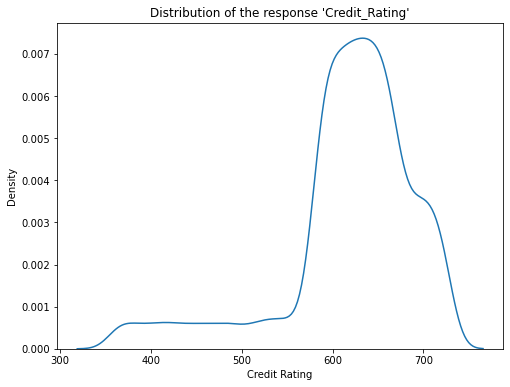

Statistical Summary of Response "Credit_Rating":


count    8035.000000
mean      617.806647
std        75.328184
min       356.061374
25%       594.703110
50%       629.308282
75%       663.400126
max       728.213085
Name: Credit_Rating, dtype: float64

In [8]:
#Plot for distribution of response
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(train_final['Credit_Rating'], ax=ax)

ax.set_title("Distribution of the response 'Credit_Rating'")
ax.set_xlabel('Credit Rating')
ax.set_ylabel('Density')
plt.show()

# Mean and standard deviation of response
print('Statistical Summary of Response "Credit_Rating":')
train_final['Credit_Rating'].describe().T

### Data cleaning & Preparation
*By Luca Moretti & Kaylee Mo & Nicket Mauskar*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we wanted to frame our problem as regression, we needed to create a new continuous variable "Credit_Rating" by assigned ranged random values based on "Poor," "Standard," and "Good" credit scores found in the column "Credit_Score". 

2. NAN values and outliers were removed to improve model accuracy and RMSE scores.

3. The training dataset was split with test_size = 0.2 and random_state = 45

In [16]:
# load train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

######---------------Creating new response 'Credit_Rating'----------------#########
train['Credit_Rating'] = 0
train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Good',
                          np.random.uniform(670, 730, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Standard',
                          np.random.uniform(580, 670, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Poor',
                          np.random.uniform(0, 580, size=len(train)),
                          train['Credit_Rating'])



######---------------Drop Irrelevant Columns----------------#########
columns_to_drop = ['Customer_ID', 'ID','Month', 'Name', 'SSN', 'Interest_Rate','Occupation',
                    'Type_of_Loan', 'Delay_from_due_date', 'Payment_Behaviour', 'Credit_History_Age', 'Credit_Score']

train.drop(columns_to_drop, axis=1, inplace=True)

######---------------Removing invalid characters from columns----------------#########
mix_type_num_col = ['Age', 'Annual_Income', 
                    'Num_of_Delayed_Payment','Changed_Credit_Limit',
                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan']

######---------------Set non numeric values in the dataset to numeric----------------#########
def set_numeric_columns(features,df=None):

    df[features]=df[features].apply(lambda x: x.replace('_','',regex=True) )
    df[features]=df[features].apply(lambda x: x.str.strip())
    df[features]=df[features].apply(lambda x: x.replace('',np.nan))
    df[features[1:]]=df[features[1:]].astype('float32')
    df[features[0]]=df[features[0]].astype('int32')

set_numeric_columns(mix_type_num_col,df=train)

######---------------Drop na values----------------#########
train = train.dropna()


######---------------Narrow down dataset to legitimate values----------------#########
train = train.loc[train.Credit_Mix != "_"]
train = train.loc[train.Payment_of_Min_Amount != "NM"]


######---------------Convert all categorical columns to quantitative----------------#########
train_dummies = pd.get_dummies(train)


######---------------Distinguish the various X and Y datasets for training and testing ----------------#########
y = train_dummies.Credit_Rating
X = train_dummies.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train


######---------------Remove outliers to decrease training RMSE(there were a lot)----------------######### 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
def remove_outliers(df, columns, threshold=3):
    print(columns)
    outliers_indices = []
    for column_name in columns:
        # Calculate the Z-scores for the specified column
        z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
        # Identify outliers based on the threshold
        outliers_indices.extend(z_scores[z_scores > threshold].index)
    
    df_no_outliers = df.drop(outliers_indices)
    return df_no_outliers

train = remove_outliers(train, train.select_dtypes(include = numerics).columns.tolist(), threshold = 1)

######---------------Create final train and test datasets for models----------------######### 
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Rating']


## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

#### Distribution of all predictors

<AxesSubplot:xlabel='Age', ylabel='Density'>

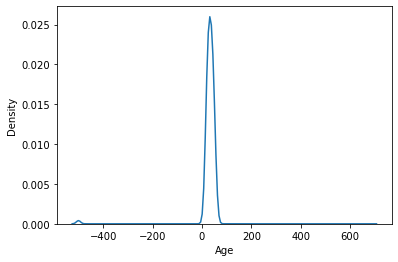

In [43]:
sns.kdeplot(train_final.Age)

<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

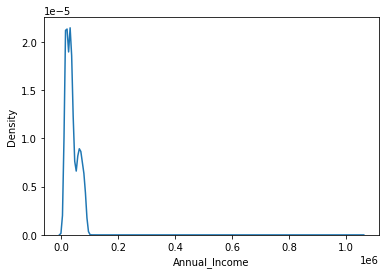

In [44]:
sns.kdeplot(train_final.Annual_Income)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Density'>

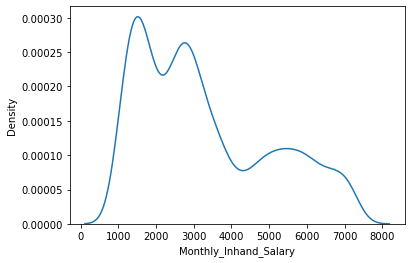

In [45]:
sns.kdeplot(train_final.Monthly_Inhand_Salary)

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Density'>

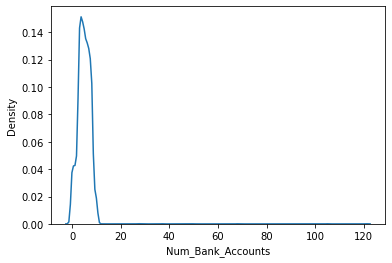

In [46]:
sns.kdeplot(train_final.Num_Bank_Accounts)

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Density'>

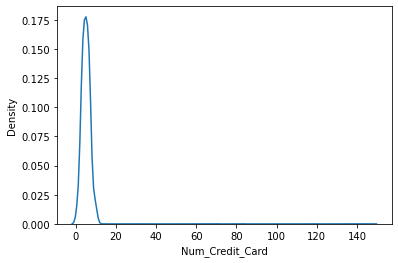

In [47]:
sns.kdeplot(train_final.Num_Credit_Card)

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Density'>

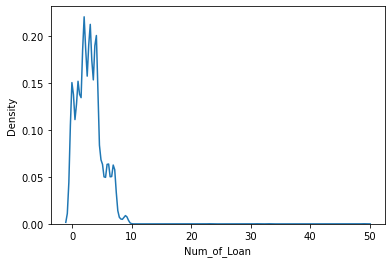

In [48]:
sns.kdeplot(train_final.Num_of_Loan)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Density'>

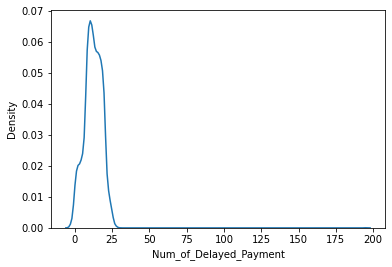

In [49]:
sns.kdeplot(train_final.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Changed_Credit_Limit', ylabel='Density'>

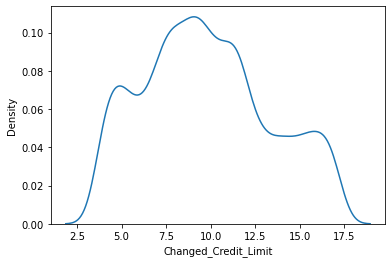

In [50]:
sns.kdeplot(train_final.Changed_Credit_Limit)

<AxesSubplot:xlabel='Num_Credit_Inquiries', ylabel='Density'>

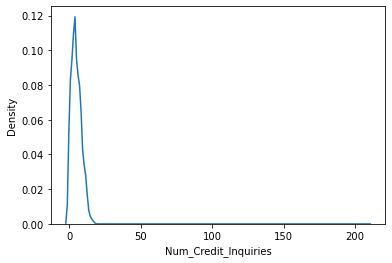

In [51]:
sns.kdeplot(train_final.Num_Credit_Inquiries)

<AxesSubplot:xlabel='Outstanding_Debt', ylabel='Density'>

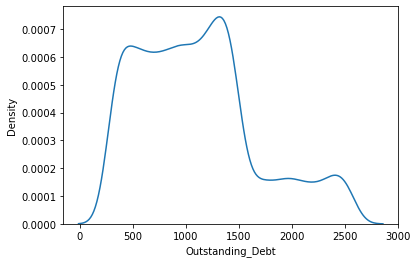

In [52]:
sns.kdeplot(train_final.Outstanding_Debt)

<AxesSubplot:xlabel='Credit_Utilization_Ratio', ylabel='Density'>

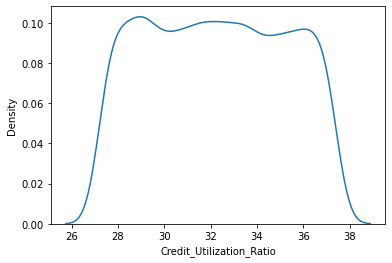

In [53]:
sns.kdeplot(train_final.Credit_Utilization_Ratio)

<AxesSubplot:xlabel='Total_EMI_per_month', ylabel='Density'>

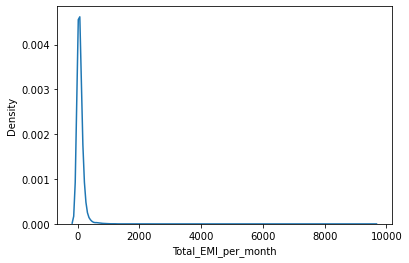

In [54]:
sns.kdeplot(train_final.Total_EMI_per_month)

<AxesSubplot:xlabel='Amount_invested_monthly', ylabel='Density'>

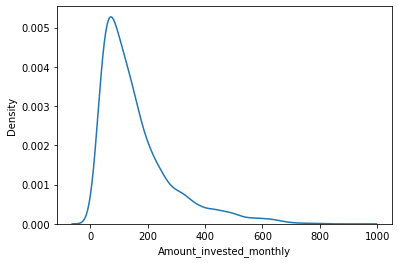

In [55]:
sns.kdeplot(train_final.Amount_invested_monthly)

<AxesSubplot:xlabel='Monthly_Balance', ylabel='Density'>

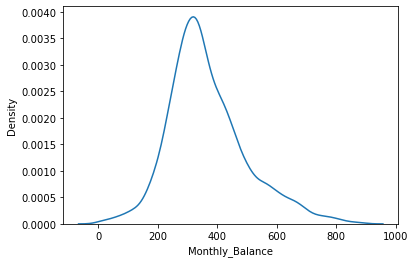

In [56]:
sns.kdeplot(train_final.Monthly_Balance)

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

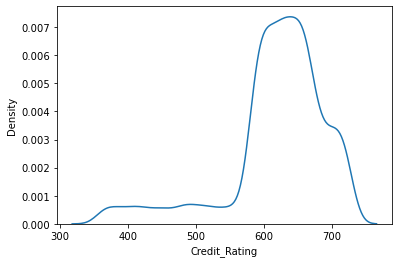

In [57]:
sns.kdeplot(train_final.Credit_Rating)

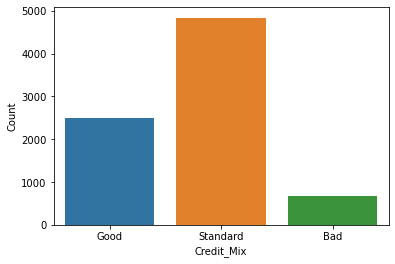

In [58]:
# Credit_Mix
sns.countplot(x='Credit_Mix', data = train)
plt.xlabel('Credit_Mix')
plt.ylabel('Count')

plt.show()

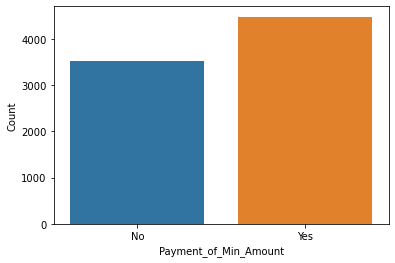

In [59]:
# Payment of Min Amount 
sns.countplot(x='Payment_of_Min_Amount', data = train)
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Count')

plt.show()

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### MARS and Bagged MARS
*By Luca Moretti*

In [5]:
# 5-fold cross validation finding optimal degree
rmse_df = pd.DataFrame(columns = {'degree', 'RMSE'})
cv = KFold(n_splits=5, random_state=1, shuffle=True)
counter = 0
for degree in np.arange(1, 10, 1):
    rmse_df.loc[counter, 'RMSE'] = np.sqrt(np.mean(-cross_val_score(Earth(max_terms=1000, max_degree = degree),
                                 X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
    rmse_df.loc[counter, 'degree'] = degree
    counter = counter + 1
    
rmse_df.loc[np.argmin(rmse_df.RMSE),:]

degree            2
RMSE      64.582452
Name: 1, dtype: object


In [6]:
# MARS model summary
model = Earth(max_terms=1000, max_degree=2, feature_importance_type= 'rss') 
model.fit(X_train,y_train)
print(model.summary())

Earth Model
---------------------------------------------------------------------------------------
Basis Function                                                   Pruned  Coefficient   
---------------------------------------------------------------------------------------
(Intercept)                                                      No      674.193       
h(Outstanding_Debt-844.81)                                       No      25.5192       
h(844.81-Outstanding_Debt)                                       Yes     None          
Credit_Mix_Good                                                  No      19.9238       
Credit_Mix_Bad                                                   No      -128.351      
h(Outstanding_Debt-1820.55)*h(Outstanding_Debt-844.81)           Yes     None          
h(1820.55-Outstanding_Debt)*h(Outstanding_Debt-844.81)           No      0.00090613    
Credit_Mix_Bad*h(Outstanding_Debt-844.81)                        No      0.0534639     
h(Num_Credit_Inquiri

In [12]:
# Initial 5-fold grid search using the following parameters
params = {'n_estimators': [200, 300, 400],
          'max_samples': [1.0, 1.5],
          'max_features': [0.25, 0.5, 0.75]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid_finer1 = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =finer_params1, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid_finer1.fit(X, y)

print('Best Parameters : ',bagging_regressor_grid_finer1.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters :  {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 400}


In [13]:
model = BaggingRegressor(base_estimator=model, n_estimators=400, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)

Test RMSE: 65.18251923571461


In [25]:
# Alternate 5-fold grid search using the following parameters
params = {'n_estimators': [250,300,350],
          'max_samples': [0.5,0.4],
          'max_features': [0.5,1.0],}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)

print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters :  {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 250}


In [18]:
model = BaggingRegressor(base_estimator=model, n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=0.5,max_samples=1.0).fit(X, y)

RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("Test RMSE:",RMSE)

Test RMSE: 64.97269572938473


In [24]:
# BEST 5-fold grid search using the following parameters
params = {'n_estimators': [200,225,250],
          'max_samples': [0.5,0.6],
          'max_features': [0.5,1.0],}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)

print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters :  {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}


In [10]:
model1 = BaggingRegressor(base_estimator=model, n_estimators=200, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=0.5,max_samples=1.0).fit(X, y)

RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("Test RMSE:",RMSE)

Test RMSE: 61.90342908024614


### Bagged Trees
*By Nicket Mauskar*

In [17]:
# Coarse Grid Search 1

# create Grid paramaters
params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

# create k-fold
cv = KFold(n_splits=5,shuffle=True,random_state=1)

# bag trees using GridSearchCV and fit
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 250}


In [32]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=0.5,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)

62.63951642827617


In [23]:
# Finer Grid Search 1

# create finer grid 1 
params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 350],
          'max_samples': [1.0],
          'max_features': [0.4, 0.5, 0.6],
          'bootstrap': [True],
          'bootstrap_features': [True, False]}
# create K-fold 
cv = KFold(n_splits=5,shuffle=True,random_state=1)

# bag trees using GridSearchCV
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 350}


In [31]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=350, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=False,bootstrap=True,
                        max_features=.6,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)

62.3023511506021


In [33]:
# Finer Grid Search 2

# create finer grid 2 
params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [350, 400],
          'max_samples': [0.5,1.0],
          'max_features': [0.6,1.0],
          'bootstrap': [True],
          'bootstrap_features': [True, False]}
# create K-fold 
cv = KFold(n_splits=5,shuffle=True,random_state=1)

# bag trees using Gr
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 400}


In [38]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators = 400, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)

62.363417489451514


In [40]:
# Finer Grid Search 3

# create finer grid 3 
params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 400],
          'max_samples': [1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True],
          'bootstrap_features': [True, False]}
# create K-fold 
cv = KFold(n_splits=5,shuffle=True,random_state=1)

# bag trees using Gr
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 400}


In [42]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators = 400, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=False,bootstrap=True,
                        max_features=0.5 ,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)

62.27130373550364


### Random forest
*By Kaylee Mo*

### XGBoost
*By Ashley Witarsa*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


In [ ]:
# MARS MODEL
model = Earth(max_terms=1000, max_degree=2, feature_importance_type= 'rss') 
MARS = BaggingRegressor(base_estimator=model, n_estimators=200, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=0.5,max_samples=1.0).fit(X, y)

### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models